<a href="https://colab.research.google.com/github/srikanth-google/ComputerVision/blob/main/opencv_text_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

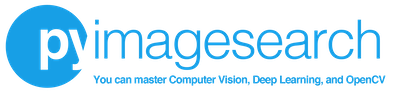

# OpenCV Text Detection (EAST text detector)
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch Plus](http://pyimg.co/plus)** Jupyter Notebooks!

This notebook is associated with the [OpenCV Text Detection (EAST text detector)](http://pyimg.co/1vorv) blog post published on 2018-08-20.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch Plus Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook.

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2020 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible joining PyImageSearch Plus at [http://pyimg.co/plus/](http://pyimg.co/plus) today.*

### Download the code zip file

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/opencv-text-detection/opencv-text-detection.zip
!unzip -qq opencv-text-detection.zip
%cd opencv-text-detection

--2025-08-07 04:27:04--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/opencv-text-detection/opencv-text-detection.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.92.194.106, 52.92.146.50, 3.5.82.181, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.92.194.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90424844 (86M) [binary/octet-stream]
Saving to: ‘opencv-text-detection.zip’

opencv-text-detecti 100%[===================>]  86.24M  73.7MB/s    in 1.2s    

2025-08-07 04:27:05 (73.7 MB/s) - ‘opencv-text-detection.zip’ saved [90424844/90424844]

/content/opencv-text-detection


## Blog Post Code

### Import Packages

In [2]:
# import the necessary packages
from imutils.object_detection import non_max_suppression
from matplotlib import pyplot as plt
from imutils.video import FPS
import numpy as np
import argparse
import imutils
import time
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
  # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Text detection in images

In [4]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", type=str,
#	help="path to input image")
#ap.add_argument("-east", "--east", type=str,
#	help="path to input EAST text detector")
#ap.add_argument("-c", "--min-confidence", type=float, default=0.5,
#	help="minimum probability required to inspect a region")
#ap.add_argument("-w", "--width", type=int, default=320,
#	help="resized image width (should be multiple of 32)")
#ap.add_argument("-e", "--height", type=int, default=320,
#	help="resized image height (should be multiple of 32)")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "images/lebron_james.jpg",
	"east": "frozen_east_text_detection.pb",
	"min_confidence": 0.5,
	"width": 320,
	"height": 320
}

In [5]:
# load the input image and grab the image dimensions
image = cv2.imread(args["image"])
orig = image.copy()
(H, W) = image.shape[:2]

# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (args["width"], args["height"])
rW = W / float(newW)
rH = H / float(newH)

# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [6]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

In [7]:
# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(args["east"])

# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

[INFO] loading EAST text detector...
[INFO] text detection took 0.987376 seconds


In [8]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]

	# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < args["min_confidence"]:
			continue
		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)
		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)
		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])

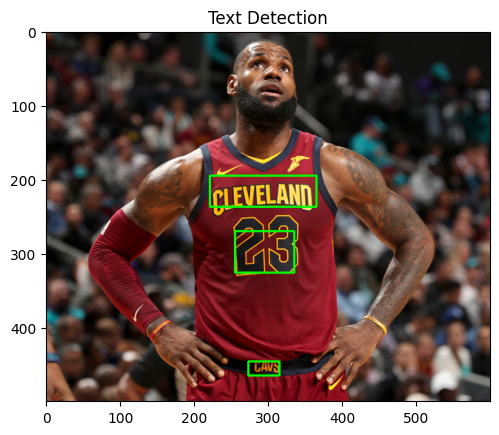

In [9]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	# draw the bounding box on the image
	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the output image
plt_imshow("Text Detection", orig)

### Text detection in video with OpenCV

In [ ]:
# first, let's get a video on which we can perform text detection
!wget https://colab-notebook-videos.s3-us-west-2.amazonaws.com/opencv+text+detection.mp4

In [ ]:
def decode_predictions(scores, geometry):
	# grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability,
			# ignore it
			if scoresData[x] < args["min_confidence"]:
				continue

			# compute the offset factor as our resulting feature
			# maps will be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)

			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]

			# compute both the starting and ending (x, y)-coordinates
			# for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)

			# add the bounding box coordinates and probability score
			# to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])

	# return a tuple of the bounding boxes and associated confidences
	return (rects, confidences)

In [ ]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-east", "--east", type=str, required=True,
#	help="path to input EAST text detector")
#ap.add_argument("-v", "--video", type=str,
#	help="path to optinal input video file")
#ap.add_argument("-c", "--min-confidence", type=float, default=0.5,
#	help="minimum probability required to inspect a region")
#ap.add_argument("-w", "--width", type=int, default=320,
#	help="resized image width (should be multiple of 32)")
#ap.add_argument("-e", "--height", type=int, default=320,
#	help="resized image height (should be multiple of 32)")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"east": "frozen_east_text_detection.pb",
    "video": "opencv+text+detection.mp4",
    "output": "output.avi",
	"min_confidence": 0.5,
	"width": 320,
	"height": 320
}

In [ ]:
# initialize the original frame dimensions, new frame dimensions,
# and ratio between the dimensions
(W, H) = (None, None)
(newW, newH) = (args["width"], args["height"])
(rW, rH) = (None, None)

# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(args["east"])

In [ ]:
# if a video path was not supplied, grab the reference to the web cam
if not args.get("video", False):
	print("[INFO] starting video stream...")
	vs = VideoStream(src=0).start()
	time.sleep(1.0)

# otherwise, grab a reference to the video file
else:
	vs = cv2.VideoCapture(args["video"])

# initialize pointer to output video file and start the FPS
# throughput estimator
writer = None
fps = FPS().start()

In [ ]:
# loop over frames from the video stream
while True:
	# grab the current frame, then handle if we are using a
	# VideoStream or VideoCapture object
	frame = vs.read()
	frame = frame[1] if args.get("video", False) else frame

	# check to see if we have reached the end of the stream
	if frame is None:
		break

	# resize the frame, maintaining the aspect ratio
	frame = imutils.resize(frame, width=1000)
	orig = frame.copy()

	# if our frame dimensions are None, we still need to compute the
	# ratio of old frame dimensions to new frame dimensions
	if W is None or H is None:
		(H, W) = frame.shape[:2]
		rW = W / float(newW)
		rH = H / float(newH)

	# resize the frame, this time ignoring aspect ratio
	frame = cv2.resize(frame, (newW, newH))

	# construct a blob from the frame and then perform a forward pass
	# of the model to obtain the two output layer sets
	blob = cv2.dnn.blobFromImage(frame, 1.0, (newW, newH),
		(123.68, 116.78, 103.94), swapRB=True, crop=False)
	net.setInput(blob)
	(scores, geometry) = net.forward(layerNames)

	# decode the predictions, then  apply non-maxima suppression to
	# suppress weak, overlapping bounding boxes
	(rects, confidences) = decode_predictions(scores, geometry)
	boxes = non_max_suppression(np.array(rects), probs=confidences)

	# loop over the bounding boxes
	for (startX, startY, endX, endY) in boxes:
		# scale the bounding box coordinates based on the respective
		# ratios
		startX = int(startX * rW)
		startY = int(startY * rH)
		endX = int(endX * rW)
		endY = int(endY * rH)

		# draw the bounding box on the frame
		cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

	# update the FPS counter
	fps.update()

  # if the video writer is None *AND* we are supposed to write
	# the output video to disk initialize the writer
	if writer is None and args["output"] is not None:
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 20,
			(orig.shape[1], orig.shape[0]), True)

	# if the writer is not None, write the frame with recognized
	# faces to disk
	if writer is not None:
		writer.write(orig)

# stop the timer and display FPS information
fps.stop()
print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# if we are using a webcam, release the pointer
if not args.get("video", False):
	vs.stop()

# otherwise, release the file pointer
else:
	vs.release()

# check to see if the video writer point needs to be released
if writer is not None:
	writer.release()

The above code block takes a while to complete its execution. If you are interested to view the video within Colab just execute the following code blocks. Note that it may be time-consuming.

Our output video is produced in `.avi` format. First, we need to convert it to `.mp4` format.

In [ ]:
!ffmpeg -i "output.avi" output.mp4

In [ ]:
#@title Display video inline
from IPython.display import HTML
from base64 import b64encode

mp4 = open("output.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)

This code is referred from [this StackOverflow thread](https://stackoverflow.com/a/57378660/7636462).

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*OpenCV Text Detection (EAST text detector)*](http://pyimg.co/1vorv) published on 2018-08-20.

# Code License Agreement
```
Copyright (c) 2020 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```